#ライブラリのインポート

In [ ]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as ipd

#データの取得と中身の確認

In [ ]:
#学習データの読み込み
train_data_dir="./drive/MyDrive/audio_dataset_3class/train/"
train_df=pd.read_csv("./drive/MyDrive/audio_dataset_3class/train.csv",index_col=0)
#テストデータの読み込み
test_data_dir="./drive/MyDrive/audio_dataset_3class/test/"
test_df=pd.read_csv("./drive/MyDrive/audio_dataset_3class/test.csv",index_col=0)

In [ ]:
#データの中身の確認
train_df.head()

,label
fname,
969b4f60.wav,Cello
3e2bddda.wav,Cello
54bb57af.wav,Cello
9d59a719.wav,Applause
05f2c2a6.wav,Clarinet


In [ ]:
#クラスごとの個数の確認
train_df["label"].value_counts()

Clarinet    130
Cello       125
Applause     60
Name: label, dtype: int64

＊ラベルはクラリネット、セロ、拍手に分類される。それに対して、音声（波形データ）が紐ついている。


In [ ]:
#波形データの中身の確認➀（数値より）
print(train_data_dir.size)

AttributeError: ignored

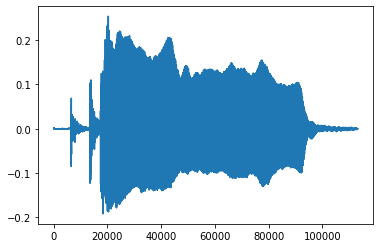

In [ ]:
#波形データの中身の確認➁（グラフより）
plt.plot(data)
plt.show()

＊波形は、時間・振幅（強度）の次元からなる。

#データの全取得と加工

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#初期化
sampling_rate=8000
audio_duration=6
audio_length=sampling_rate*audio_duration
#ラベルごと数値を紐付ける(directionary)
audio_label_dict={"Cello":0,"Clarinet":1,"Applause":2} 

In [ ]:
#複数ファイルより、データの取得
def load_files(data_dir,filenames):
  result=[]
  #enumerateはよく使用するので復習しておくよい。
  for i,filename in enumerate(filenames):
    #ファイルパスの取得
    file_path=data_dir+filename
    #ファイルパスを指定して、dataのみを取得し、リストに格納している。
    data,_=librosa.core.load(file_path,sr=sampling_rate,res_type='kaiser_fast')
    #リストに結合する。
    result.append(data)
  return result

In [ ]:
#音声データの加工を実行（モデルに渡せるように）
def create_audio_dataset(train_df,test_df,train_data_dir,test_data_dir,audio_label_dict):
  dim=(audio_length,1)#二次元でサイズを指定
  train_filenames=train_df.index
  test_filenames=test_df.index

  #ファイルを指定して、データを取得している。
  X_train=load_files(train_data_dir,train_filenames)
  X_test=load_files(test_data_dir,test_filenames)

  #データのサイズを固定し、合わせる→モデルにデータを渡すときは、データの型やサイズについて統合しておく必要がある。
  X_train_post=pad_sequences(X_train,dtype='float32',maxlen=audio_length,padding='pre',truncating='pre',value=0.0).tolist()
  X_test_post=pad_sequences(X_test,dtype='float32',maxlen=audio_length,padding='pre',truncating='pre',value=0.0).tolist()

  #スケール変換により、平均値を0と分散1に変換する。
  scaler=StandardScaler()
  scaler=scaler.fit(X_train_post+X_test_post)
  X_train_post=scaler.transform(X_train_post)
  X_test_post=scaler.transform(X_test_post)

  #三次元配列(ファイル数、波形長、1)の作成とデータの格納
  X_train_ary=np.empty((len(train_filenames),*dim))
  for index,data in enumerate(X_train_post):
    X_train_ary[index,]=[[d] for d in data] #内包表記を使用している。復習しておくとよい。

  X_test_ary=np.empty((len(test_filenames),*dim))
  for index,data in enumerate(X_test_post):
    X_test_ary[index,]=[[d] for d in data]

  #ラベルデータの取得
  labels_train=train_df["label"]
  labels_test=test_df["label"]

  #ディレクショナリを応用して、KeyよりValueを取得して、リストに格納する。
  Y_train_ary=np.empty(len(labels_train),dtype=int)
  for index,label in enumerate(labels_train):
    Y_train_ary[index]=audio_label_dict[label]

  Y_test_ary=np.empty(len(labels_test),dtype=int)
  for index,label in enumerate(labels_test):
    Y_test_ary[index]=audio_label_dict[label]
  
  #one-hot化
  Y_train_result=to_categorical(Y_train_ary,num_classes=len(audio_label_dict))
  Y_test_result=to_categorical(Y_test_ary,num_classes=len(audio_label_dict))

  return X_train_ary,Y_train_result,X_test_ary,Y_test_result

In [ ]:
#データ加工処理の実施
X_train,Y_train,X_test,Y_test=create_audio_dataset(train_df,test_df,train_data_dir,test_data_dir,audio_label_dict)

In [ ]:
#X_train,X_test→(データ数、波形長、1) Y_train,Y_test→(データ数,クラス数)
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((316, 24000, 1), (316, 3), (142, 24000, 1), (142, 3))

#モデルの定義

In [ ]:
from tensorflow.keras.layers import Dense,LSTM,Dropout,Bidirectional,Activation,Conv1D,MaxPooling1D,GlobalMaxPool1D,GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#学習途中のモデルを保存するディレクトリの定義とチェックポイントの指定
model_dir = "./drive/My Drive/temp"
# 保存ディレクトリが存在しない場合、作成する。
if not os.path.exists(model_dir):  
    os.makedirs(model_dir)
#学習がどこまで進行しているかを保存する。
checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_dir, "model-{epoch:02d}.h5"), save_best_only=True)

In [ ]:
#モデルの定義
def model_create(state):
  #lstmの定義
  if state==0:
    weight_decay=1e-4
    input_shape=(audio_length,1)
    model_lstm=Sequential()#Sequentialの使用
    model_lstm.add(LSTM(128,return_sequences=True,dropout=0.25,input_shape=input_shape))
    model_lstm.add(LSTM(128,return_sequences=True,dropout=0.25))
    model_lstm.add(LSTM(128,return_sequences=False,dropout=0.25,kernel_regularizer=regularizers.l2(weight_decay)))
    model_lstm.add(Dense(units=len(audio_label_dict),activation="softmax"))
    #ラベルが整数の場合は、損失関数としてsparse_categorical_crossentropy を使用する。
    model_lstm.compile(loss="categorical_crossentropy",optimizer=Adam(0.001),metrics=["acc"])
    return model_lstm
  #cnnの定義
  elif state==1:
    #モデルの構築
    input_shape=(audio_length,1)
    model_cnn=Sequential()
    #Conv1Dは一次元データに対する畳み込み層
    model_cnn.add(Conv1D(filters=128,kernel_size=9,padding='valid',input_shape=input_shape,activation='relu'))
    #pooling層（圧縮）
    model_cnn.add(MaxPooling1D(pool_size=16))
    #Dropout層（ユニットが保持しているデータの一部は次の隣あったユニットには渡さない）→過学習を防ぐ
    model_cnn.add(Dropout(rate=0.20))

    model_cnn.add(Conv1D(filters=64,kernel_size=3,padding='valid',input_shape=input_shape,activation='relu'))
    model_cnn.add(GlobalMaxPool1D())
    model_cnn.add(Dropout(rate=0.20))
    #Dense層→全結合層　活性化関数(softmax)
    model_cnn.add(Dense(len(audio_label_dict),activation="softmax"))
    #ラベルがone-hot エンコーディングで表現されている場合は、損失関数としてcategorical_crossentropy を使用する。
    model_cnn.compile(optimizer=Adam(0.001),loss='categorical_crossentropy',metrics=['acc'])
    return model_cnn
  #gruの定義
  elif state==2:
    input_shape=(audio_length,1)
    model_gru = Sequential()
    model_gru.add(GRU(128,return_sequences=True,dropout=0.3,input_shape=input_shape))
    model_gru.add(GRU(128,return_sequences=False,dropout=0.3))
    model_gru.add(Dense(units=len(audio_label_dict),activation="softmax"))
    model_gru.compile(optimizer=Adam(0.001),loss='categorical_crossentropy',metrics=['acc'])
    return model_gru

In [ ]:
#フラグ設定によって、使用するモデルを選択する。
state=2
#モデルの選択と構築
model_post=model_create(state)
model_post.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 24000, 128)        50304     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 149,763
Trainable params: 149,763
Non-trainable params: 0
_________________________________________________________________


#学習の実行

In [ ]:
#再度モデルを読み込む場合
'''
model_post.load_weights(os.path.join(model_dir, "model-23.h5"))  # 最新のモデルを指定

if not os.path.exists(model_dir):  # ディレクトリが存在しない場合、作成する。
    os.makedirs(model_dir)
checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_dir, "model_new-{epoch:02d}.h5"), 
    monitor = 'loss',
    save_best_only=True,
    mode='min',
    period=1) 
'''
# 学習開始もしくは再開

history=model_post.fit(X_train,Y_train,batch_size=16,epochs=70,validation_split=0.1,verbose=1, callbacks=[checkpoint])

 8/18 [============>.................] - ETA: 52s - loss: 0.9141 - acc: 0.5156

KeyboardInterrupt: ignored

##学習済みモデルの評価(数値）

#GRUの場合

In [ ]:
#予測の実施
predictions=model_post.predict(X_test,verbose=1)
#予測した結果
#クラス分類では、Argmaxがなじむようである。もっとも、Argmaxは配列のうち、最も大きな値のインデックスを取得する。
pred_labels=np.array([np.argmax(pred) for pred in predictions])
#目標データ
actual_labels=np.array([audio_label_dict[lab] for lab in test_df["label"]])
#予測結果と目標データの一致の割合の算出
temp=actual_labels==pred_labels
temp.sum()/len(temp)

5/5 [==============================] - 12s 2s/step


0.4225352112676056

#CNNの場合

In [ ]:
#予測の実施
predictions=model_post.predict(X_test,verbose=1)
#予測した結果
#クラス分類では、Argmaxがなじむようである。もっとも、Argmaxは配列のうち、最も大きな値のインデックスを取得する。
pred_labels=np.array([np.argmax(pred) for pred in predictions])
#目標データ
actual_labels=np.array([audio_label_dict[lab] for lab in test_df["label"]])
#予測結果と目標データの一致の割合の算出
temp=actual_labels==pred_labels
temp.sum()/len(temp)

5/5 [==============================] - 1s 141ms/step


0.9295774647887324

##学習済みモデルの評価(可視データ）

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#CNNの場合

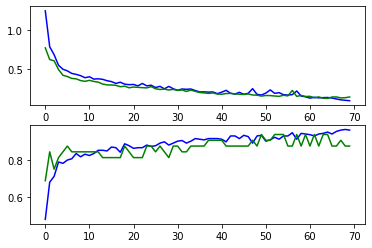

In [ ]:
#損失度/精度について、学習用と検証用それぞれ別々に評価する。
fig,ax=plt.subplots(2,1) #2行1列のグラフを表示する。
ax[0].plot(history.history["loss"],color="b",label="Training loss")
ax[0].plot(history.history["val_loss"],color="g",label="Validation loss")
ax[0].legend #凡例の表示

ax[1].plot(history.history["acc"],color="b",label="Training Accuracy")
ax[1].plot(history.history["val_acc"],color="g",label="Validation Accuracy")
ax[1].legend

plt.show()

[]

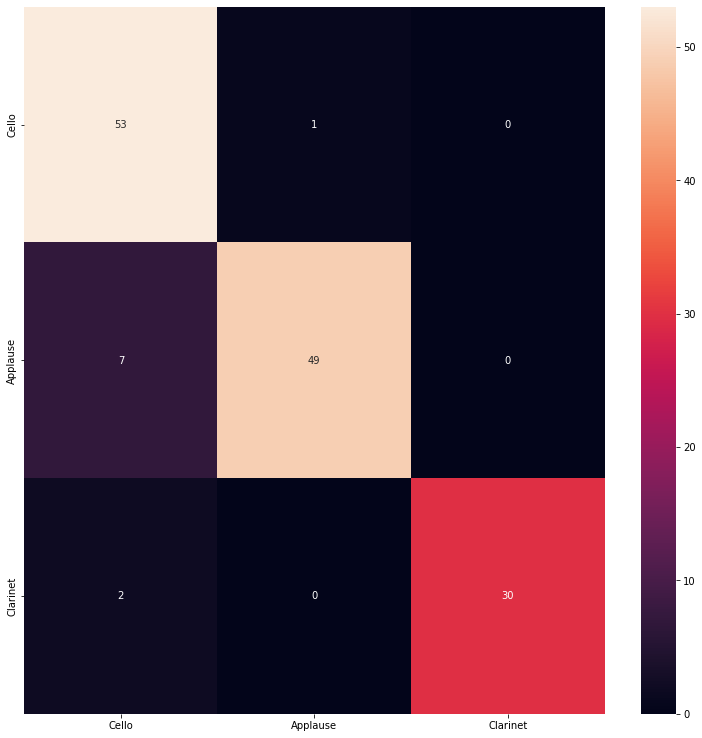

In [ ]:
#混合行列の作成
cf_matrix=confusion_matrix(actual_labels,pred_labels)
plt.figure(figsize=(13,13))
c=sns.heatmap(cf_matrix,annot=True,fmt="d")
audio_label_list={"Cello","Clarinet","Applause"}
c.set(xticklabels=audio_label_list,yticklabels=audio_label_list)
plt.plot()